In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import gc
import re
import json
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

import matplotlib.dates as mdates

# This notebook calculates retraction batch sizes from any pull of the Retraction Watch Database: https://retractiondatabase.org/

The pull of the RWDB used in the study was 4 March, 2024

In [2]:
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
rw_db = rw_db[rw_db['RetractionNature'] == 'Retraction'].copy()

rw_db['retraction_date'] = pd.to_datetime(rw_db['RetractionDate'])
rw_db['retraction_year'] = [x.year for x in rw_db['retraction_date']]
rw_db['original_paper_date'] = pd.to_datetime(rw_db['OriginalPaperDate'])
rw_db['original_paper_year'] = [x.year for x in rw_db['original_paper_date']]

rw_db_groupby_date_journal = rw_db.groupby(['Journal', 'Publisher', 'retraction_date'])['Record ID'].nunique().reset_index()

rw_db_groupby_date_journal['retraction_year'] = [x.year for x in rw_db_groupby_date_journal['retraction_date']]

In [3]:
threshs = [1,2,11, 10_000]

rw_db_groupby_date_journal['cat'] = ''

for index in range(len(threshs)-1):
    rw_db_groupby_date_journal.loc[(rw_db_groupby_date_journal['Record ID'] >= threshs[index]) & 
                                   (rw_db_groupby_date_journal['Record ID'] < threshs[index+1]), 'cat'] = \
    threshs[index]

In [4]:
year_df_by_retraction_event = rw_db_groupby_date_journal.groupby(['retraction_year', 'cat']).count()
year_df_by_retraction_event = \
year_df_by_retraction_event.reset_index().pivot(index='retraction_year', columns='cat', values='Record ID')\
.reindex(np.arange(1970,2026)).fillna(0.0)

year_df_by_retraction = rw_db_groupby_date_journal.groupby(['retraction_year', 'cat']).sum()
year_df_by_retraction = \
year_df_by_retraction.reset_index().pivot(index='retraction_year', columns='cat', values='Record ID')\
.reindex(np.arange(1970,2026)).fillna(0.0)

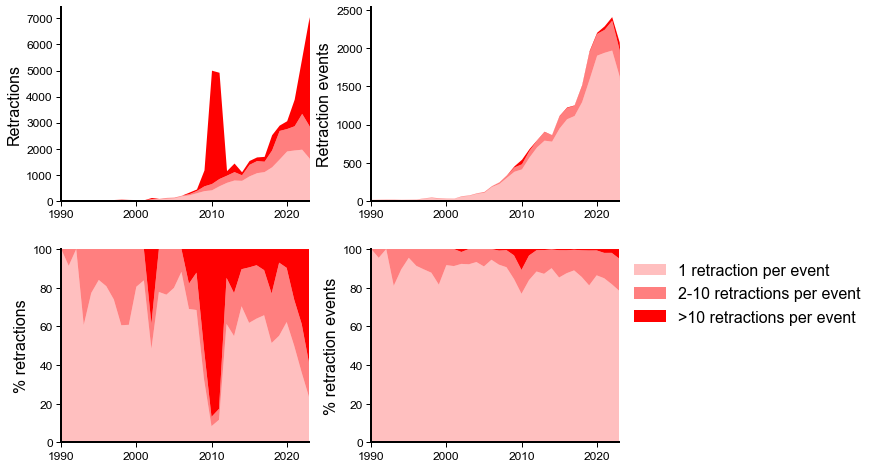

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), gridspec_kw={'hspace':0.25, 'wspace':0.25})

labels = ['1 retraction per event', 
          '2-10 retractions per event', 
          '>10 retractions per event']
ax = axes[0][0]
for index, alpha in zip(range(len(threshs)-1), [0.25,0.5,1.0]):
    ax.fill_between(x=year_df_by_retraction.index.values, 
                     y1=year_df_by_retraction[threshs[0:index]].sum(axis=1), 
                     y2=year_df_by_retraction[threshs[0:index+1]].sum(axis=1), 
                     linewidth=0, color='r', alpha=alpha)
ax.set_ylabel('Retractions', fontsize=16)

ax = axes[1][0]
for index, alpha in zip(range(len(threshs)-1), [0.25,0.5,1.0]):
    ax.fill_between(x=year_df_by_retraction.index.values, 
                     y1=100*year_df_by_retraction[threshs[0:index]].sum(axis=1)/year_df_by_retraction.sum(axis=1), 
                     y2=100*year_df_by_retraction[threshs[0:index+1]].sum(axis=1)/year_df_by_retraction.sum(axis=1), 
                     linewidth=0, color='r', alpha=alpha)
ax.set_ylabel('% retractions', fontsize=16)
ax.set_ylim([0,100])

ax = axes[0][1]
for index, alpha in zip(range(len(threshs)-1), [0.25,0.5,1.0]):
    ax.fill_between(x=year_df_by_retraction_event.index.values, 
                     y1=year_df_by_retraction_event[threshs[0:index]].sum(axis=1), 
                     y2=year_df_by_retraction_event[threshs[0:index+1]].sum(axis=1), 
                     linewidth=0, color='r', alpha=alpha)
ax.set_ylabel('Retraction events', fontsize=16)

ax = axes[1][1]
for index, alpha, label in zip(range(len(threshs)-1), [0.25,0.5,1.0], labels):
    ax.fill_between(x=year_df_by_retraction_event.index.values, 
                     y1=100*year_df_by_retraction_event[threshs[0:index]].sum(axis=1)/year_df_by_retraction_event.sum(axis=1), 
                     y2=100*year_df_by_retraction_event[threshs[0:index+1]].sum(axis=1)/year_df_by_retraction_event.sum(axis=1), 
                     linewidth=0, color='r', alpha=alpha, label=label)
ax.set_ylabel('% retraction events', fontsize=16)
ax.set_ylim([0,100])
ax.legend(fontsize=16, frameon=False, bbox_to_anchor=(1,1), loc='upper left')

for ax in axes.flatten():
    ax.set_xlim([1990,2023])
    ax.set_ylim(bottom=0)
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    
#fig.savefig('../img/240304_retraction_composition_by_year.png', dpi=200, bbox_inches='tight')

In [6]:
#year_df_by_retraction.to_csv('../data/240421_retractions_by_year_by_batch_size.csv')